<a href="https://colab.research.google.com/github/jydiw/nyt-covid-19-data/blob/master/eda_nytimes-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYTimes COVID-19 EDA

In [143]:
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

from urllib.request import urlopen
import json

import itertools

from time import time
from datetime import datetime, timedelta

from shapely.geometry import Polygon

# import nytimes data

New York Times data has a few caveats, including treating New York City, Kansas City, and Joplin as single entities rather than including them in their respective counties. Read their [README](https://github.com/nytimes/covid-19-data/blob/master/README.md) for more information.

In [2]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = pd.read_csv(response)
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [3]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337568 entries, 0 to 337567
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    337568 non-null  object 
 1   county  337568 non-null  object 
 2   state   337568 non-null  object 
 3   fips    334129 non-null  float64
 4   cases   337568 non-null  int64  
 5   deaths  337568 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 15.5+ MB


In [4]:
for col in nyt_df.select_dtypes(include='object').columns:
    print(col)
    print(len(nyt_df[col].unique()))
    print()

date
177

county
1901

state
55



- `fips` should not be numeric. As we'll see down below, we will have to import this as an object type so that we don't convert `float` values to `str`.
- the max for both `cases` and `deaths` is well below the maximum value of `int64`, so we can downcast.
- by nature of the data, the `state`-`county` combinations (and therefore `fips`) are far fewer than the number of entries in our dataset. We can change `state`, `county`, and `fips` to the `category` data type.
- we should probably change `date` into a `datetime` data type. This gives us some flexibility later.

**Why `category`?** The memory of the `object` data type is proportional to its length, whereas for `category` it is proportional to the number of categories plus the length. Given that we have 300k+ rows and only 1814 unique counties, we save memory when converting that column to `category`.

https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#memory-usage

In [5]:
nyt_df['fips'] = nyt_df['fips'].astype('category')   # doesn't work as intended
nyt_df['cases'] = pd.to_numeric(nyt_df['cases'], downcast='integer')
nyt_df['deaths'] = pd.to_numeric(nyt_df['deaths'], downcast='integer')
nyt_df['state'] = nyt_df['state'].astype('category')
nyt_df['county'] = nyt_df['county'].astype('category')
nyt_df['date'] = pd.to_datetime(nyt_df['date'])
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [6]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337568 entries, 0 to 337567
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    337568 non-null  datetime64[ns]
 1   county  337568 non-null  category      
 2   state   337568 non-null  category      
 3   fips    334129 non-null  category      
 4   cases   337568 non-null  int32         
 5   deaths  337568 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 6.4 MB


We reduce our memory usage by over half. While we were not using an absolute large amount of memory prior to optimization, it's good practice to optimize your code.

Combining into one function:

In [7]:
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col: pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    return dft

In [8]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [9]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337568 entries, 0 to 337567
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    337568 non-null  datetime64[ns]
 1   county  337568 non-null  category      
 2   state   337568 non-null  category      
 3   fips    334129 non-null  category      
 4   cases   337568 non-null  int32         
 5   deaths  337568 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 6.4 MB


# import census and GeoJSON data

We want to calculate ratios comparing the number of cases (or deaths) to the population and/or area of the county. Since the population density varies wildly per county, relying on just the absolute number of reported cases could be misleading.

In [10]:
# pop_df = pd.read_csv('data/pop_df.csv')
with urlopen('https://raw.githubusercontent.com/jydiw/nyt-covid-19-data/master/data/pop_df.csv') as response:
    pop_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))
pop_df.head()

,state,county,population,fips,area,lon,lat,pop_per_area
0,Alabama,Autauga,55869,01001,594.435974,-86.641197,32.536152,93.986572
1,Alabama,Baldwin,223234,01003,1589.784058,-87.723953,30.725863,140.417816
2,Alabama,Barbour,24686,01005,884.875977,-85.389244,31.867889,27.897696
3,Alabama,Bibb,22394,01007,622.581970,-87.124962,32.996456,35.969563
4,Alabama,Blount,57826,01009,644.776001,-86.569756,33.985249,89.683861


In [125]:
pop_df.sort_values(by='population').iloc[[0, -1]]

,state,county,population,fips,area,lon,lat,pop_per_area
548,Hawaii,Kalawao,86,15005,11.991000,-156.951126,21.175037,7.172046
204,California,Los Angeles,10039107,06037,4057.884033,-118.216835,34.357796,2473.975830


In [11]:
pop_df.sort_values(by='pop_per_area').iloc[[0, -1]]

,state,county,population,fips,area,lon,lat,pop_per_area
95,Alaska,Yukon-Koyukuk Census Area,5230,02290,145504.78125,-151.390030,65.508743,0.035944
1858,New York,New York,1628706,36061,22.82900,-73.962898,40.783318,71343.726562


There are several things to consider:

- New York City will clearly report more cases than Yukon-Koyukuk, as it's orders of magnitude more populous. Reporting cases as a percentage (or as we'll use later, a per 100k) would better reflect the severity of infections.
- However, a higher population density would likely make it easier to transmit the disease to another person. Looking at the day-to-day change in new cases could allow us to see how quickly the disease is spreading.

In [12]:
nyt_df = nyt_df[nyt_df['county'] != 'Unknown']
list(set(nyt_df['county']) - set(pop_df['county']))

['Las Marias',
 'Rincon',
 'Anasco',
 'Loiza',
 'Mayaguez',
 'Comerio',
 'Catano',
 'Penuelas',
 'Tinian',
 'Canovanas',
 'San German',
 'Saipan',
 'Juana Diaz',
 'San Sebastian',
 'Bayamon',
 'Manati',
 'Guanica']

The NYTimes dataset does not include diacritical marks for the names of Puerto Rico's municipios. In the interest of cultural accuracy, we will preserve them when merging with `pop_df`. 

The NYTimes dataset deals with New York City, Kansas City, and Joplin as their own entities. As such, they do not have valid `fips` codes; we must add our custom `fips` from our earlier census EDA.

In [13]:
nyt_df['fips'] = nyt_df['fips'].astype('object')
nyt_df.loc[nyt_df['county'] == 'New York City','fips'] = 'nyc'
nyt_df.loc[nyt_df['county'] == 'Kansas City','fips'] = 'kc'
nyt_df.loc[nyt_df['county'] == 'Joplin','fips'] = 'jm'
nyt_df['fips'] = nyt_df['fips'].astype('category')

# merge `nyt_df` and `pop_df` for feature engineering

In [127]:
tick = time()

df = nyt_df.merge(pop_df, on='fips', suffixes=('_x','')).drop(['county_x', 'state_x'], axis=1)

# person density
df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['population'], axis=0) * 100_000
# df[['cases_per_100k', 'deaths_per_100k']] = df[['cases_per_100k', 'deaths_per_100k']].round(4)

df = df.sort_values(by=['date', 'fips'])

tock = time()
print(tock - tick)
print(df.shape)
df.head()

0.2534177303314209
(334401, 13)


,date,fips,cases,deaths,state,county,population,area,lon,lat,pop_per_area,cases_per_100k,deaths_per_100k
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0
177,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.325989,-87.817429,41.839622,5448.102539,0.019417,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0


In [16]:
df.to_csv('data/df-no-trends.csv', index=False)

FileNotFoundError: ignored

In [17]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']
new_cols = ['new_' + c for c in cols]
delta_cols = ['delta_' + c for c in new_cols]

cols_7d = [c + '_7d' for c in cols]
new_cols_7d = ['new_' + c for c in cols_7d]
delta_cols_7d = ['delta_' + c for c in new_cols_7d]

In [18]:
def add_change_cols(df, cols, pre='new_', clip=True):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_avg_cols(df, cols, window=7):
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'd' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].apply(lambda x: x.rolling(window, min_periods=1).mean())
    return (df, cols_d)

In [167]:
ding = time()
df, cols_7d = add_avg_cols(df, cols, window=7)
df, new_cols = add_change_cols(df, cols, pre='new_', clip=True)
df, new_cols_7d = add_change_cols(df, cols_7d, pre='new_', clip=True)
df, _ = add_change_cols(df, new_cols, pre='delta_', clip=False)
df, _ = add_change_cols(df, new_cols_7d, pre='delta_', clip=False)
dong = time()
print(dong - ding)
print(df.columns)
df.head()

8.636837005615234
Index(['date', 'fips', 'cases', 'deaths', 'state', 'county', 'population',
       'area', 'lon', 'lat', 'pop_per_area', 'cases_per_100k',
       'deaths_per_100k', 'cases_7d', 'deaths_7d', 'cases_per_100k_7d',
       'deaths_per_100k_7d', 'new_cases', 'new_deaths', 'new_cases_per_100k',
       'new_deaths_per_100k', 'new_cases_7d', 'new_deaths_7d',
       'new_cases_per_100k_7d', 'new_deaths_per_100k_7d', 'delta_new_cases',
       'delta_new_deaths', 'delta_new_cases_per_100k',
       'delta_new_deaths_per_100k', 'delta_new_cases_7d',
       'delta_new_deaths_7d', 'delta_new_cases_per_100k_7d',
       'delta_new_deaths_per_100k_7d'],
      dtype='object')


,date,fips,cases,deaths,state,county,population,area,lon,lat,pop_per_area,cases_per_100k,deaths_per_100k,cases_7d,deaths_7d,cases_per_100k_7d,deaths_per_100k_7d,new_cases,new_deaths,new_cases_per_100k,new_deaths_per_100k,new_cases_7d,new_deaths_7d,new_cases_per_100k_7d,new_deaths_per_100k_7d,delta_new_cases,delta_new_deaths,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7d,delta_new_deaths_7d,delta_new_cases_per_100k_7d,delta_new_deaths_per_100k_7d
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.325989,-87.817429,41.839622,5448.102539,0.019417,0.0,1.0,0.0,0.019417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.to_csv('data/df.csv', index=False)

## rolling regression instead of rolling average

To do: find a faster way to do this!

In [186]:
def add_slope_cols(df, cols, window=7):
    df = df.sort_values(by=['date', 'fips'])
    cols_s = [c + '_' + str(window) + 's' for c in cols]

    # https://stackoverflow.com/a/34668038
    d = dict.fromkeys(cols_s, 0)
    df = df.assign(**d)
    
    for n, fips in enumerate(df['fips'].unique()):
        f = len(df['fips'].unique())
        if (n + 1) % 300 == 0:
            print(f'{n+1} of {f} fips')
        dft = df[df['fips'] == fips][cols].values
        l = len(dft)
        preds = np.zeros((1, dft.shape[1]))        # first row of slopes is 0
        if l > 1:                                   # if we have more rows
            for i in range(2, np.min([l+1, window])):
                x = np.arange(i)                    # emulating min_period=2
                y = dft[0:i]
                # https://stackoverflow.com/a/18767992
                coefs = poly.polyfit(x, y, 1)
                pred = [poly.polyval(x[-1], coefs)]
                preds = np.append(preds, pred, axis=0)
            if l > window:
                x = np.arange(window)
                for j in range(window, l+1):
                    y = dft[j-window:j]         # find slope of previous window
                    coefs = poly.polyfit(x, y, 1)
                    pred = [poly.polyval(x[-1], coefs)]
                    preds = np.append(preds, pred, axis=0)
        if not (dft.shape == preds.shape):
            print(fips)
            break
        df.loc[df['fips'] == fips, cols_s] = preds
    return (df, cols_s)

In [183]:
w = 7
s = 20
x = np.arange(w)
y = dft[s:s+w]
preds = np.zeros((1, dft.shape[1]))
coefs = poly.polyfit(x, y, 1)
pred = [poly.polyval(x[-1], coefs)]
preds = np.append(preds, pred, axis=0)
preds

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.59537500e+04, 5.14357143e+02, 3.11314858e+02, 6.16970653e+00]])

In [181]:
y[x[-1]]

array([2.55090000e+04, 5.60000000e+02, 3.05980088e+02, 6.71719195e+00])

In [187]:
tick = time()
df, cols_7s = add_slope_cols(df, cols)
tock = time()
print()
print(tock - tick)
df.info()

300 of 3167 fips
600 of 3167 fips
900 of 3167 fips
1200 of 3167 fips
1500 of 3167 fips
1800 of 3167 fips
2100 of 3167 fips
2400 of 3167 fips
2700 of 3167 fips
3000 of 3167 fips

231.92249155044556
<class 'pandas.core.frame.DataFrame'>
Int64Index: 334401 entries, 0 to 3959
Data columns (total 45 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date                          334401 non-null  datetime64[ns]
 1   fips                          334401 non-null  object        
 2   cases                         334401 non-null  int32         
 3   deaths                        334401 non-null  int16         
 4   state                         334401 non-null  category      
 5   county                        334401 non-null  object        
 6   population                    334401 non-null  int32         
 7   area                          334401 non-null  float32       
 8   lon                

In [188]:
ding = time()
df, new_cols_7s = add_change_cols(df, cols_7s, pre='new_', clip=True)
df, delta_new_cols_7s = add_change_cols(df, new_cols_7s, pre='delta_', clip=False)
dong = time()
print(dong - ding)
print(df.columns)
df.head()

0.3821585178375244
Index(['date', 'fips', 'cases', 'deaths', 'state', 'county', 'population',
       'area', 'lon', 'lat', 'pop_per_area', 'cases_per_100k',
       'deaths_per_100k', 'cases_7d', 'deaths_7d', 'cases_per_100k_7d',
       'deaths_per_100k_7d', 'new_cases', 'new_deaths', 'new_cases_per_100k',
       'new_deaths_per_100k', 'new_cases_7d', 'new_deaths_7d',
       'new_cases_per_100k_7d', 'new_deaths_per_100k_7d', 'delta_new_cases',
       'delta_new_deaths', 'delta_new_cases_per_100k',
       'delta_new_deaths_per_100k', 'delta_new_cases_7d',
       'delta_new_deaths_7d', 'delta_new_cases_per_100k_7d',
       'delta_new_deaths_per_100k_7d', 'cases_7s', 'deaths_7s',
       'cases_per_100k_7s', 'deaths_per_100k_7s', 'new_cases_7s',
       'new_deaths_7s', 'new_cases_per_100k_7s', 'new_deaths_per_100k_7s',
       'delta_new_cases_7s', 'delta_new_deaths_7s',
       'delta_new_cases_per_100k_7s', 'delta_new_deaths_per_100k_7s'],
      dtype='object')


,date,fips,cases,deaths,state,county,population,area,lon,lat,pop_per_area,cases_per_100k,deaths_per_100k,cases_7d,deaths_7d,cases_per_100k_7d,deaths_per_100k_7d,new_cases,new_deaths,new_cases_per_100k,new_deaths_per_100k,new_cases_7d,new_deaths_7d,new_cases_per_100k_7d,new_deaths_per_100k_7d,delta_new_cases,delta_new_deaths,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7d,delta_new_deaths_7d,delta_new_cases_per_100k_7d,delta_new_deaths_per_100k_7d,cases_7s,deaths_7s,cases_per_100k_7s,deaths_per_100k_7s,new_cases_7s,new_deaths_7s,new_cases_per_100k_7s,new_deaths_per_100k_7s,delta_new_cases_7s,delta_new_deaths_7s,delta_new_cases_per_100k_7s,delta_new_deaths_per_100k_7s
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.121642,0.0,1.000000e+00,0.0,1.216422e-01,0.0,1.000000e+00,0.0,1.216422e-01,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.121642,0.0,5.551115e-16,0.0,6.938894e-17,0.0,-1.000000e+00,0.0,-1.216422e-01,0.0
177,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.325989,-87.817429,41.839622,5448.102539,0.019417,0.0,1.0,0.0,0.019417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.121642,0.0,0.000000e+00,0.0,2.775558e-17,0.0,-5.551115e-16,0.0,-4.163336e-17,0.0


In [190]:
temp_cols = [col for col in df.columns if col[-2:] == '7s']
temp_cols

['cases_7s',
 'deaths_7s',
 'cases_per_100k_7s',
 'deaths_per_100k_7s',
 'new_cases_7s',
 'new_deaths_7s',
 'new_cases_per_100k_7s',
 'new_deaths_per_100k_7s',
 'delta_new_cases_7s',
 'delta_new_deaths_7s',
 'delta_new_cases_per_100k_7s',
 'delta_new_deaths_per_100k_7s']

In [192]:
df[temp_cols] = df[temp_cols].round(4)

In [193]:
df.head()

,date,fips,cases,deaths,state,county,population,area,lon,lat,pop_per_area,cases_per_100k,deaths_per_100k,cases_7d,deaths_7d,cases_per_100k_7d,deaths_per_100k_7d,new_cases,new_deaths,new_cases_per_100k,new_deaths_per_100k,new_cases_7d,new_deaths_7d,new_cases_per_100k_7d,new_deaths_per_100k_7d,delta_new_cases,delta_new_deaths,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7d,delta_new_deaths_7d,delta_new_cases_per_100k_7d,delta_new_deaths_per_100k_7d,cases_7s,deaths_7s,cases_per_100k_7s,deaths_per_100k_7s,new_cases_7s,new_deaths_7s,new_cases_per_100k_7s,new_deaths_per_100k_7s,delta_new_cases_7s,delta_new_deaths_7s,delta_new_cases_per_100k_7s,delta_new_deaths_per_100k_7s
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1216,0.0,1.0,0.0,0.1216,0.0,1.0,0.0,0.1216,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1216,0.0,0.0,0.0,0.0000,0.0,-1.0,0.0,-0.1216,0.0
177,2020-01-24,17031,1,0,Illinois,Cook,5150233,945.325989,-87.817429,41.839622,5448.102539,0.019417,0.0,1.0,0.0,0.019417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,2087.272949,-121.692780,48.046917,393.855042,0.121642,0.0,1.0,0.0,0.121642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1216,0.0,0.0,0.0,0.0000,0.0,-0.0,0.0,-0.0000,0.0


In [194]:
df[df['fips'] == 'nyc'][['new_deaths','new_deaths_7d', 'new_deaths_7s']].head(20)

,new_deaths,new_deaths_7d,new_deaths_7s
3823,0.0,0.000000,0.0000
3824,0.0,0.000000,0.0000
3825,0.0,0.000000,0.0000
3826,0.0,0.000000,0.0000
3827,0.0,0.000000,0.0000
3828,0.0,0.000000,0.0000
3829,0.0,0.000000,0.0000
3830,0.0,0.000000,0.0000
3831,0.0,0.000000,0.0000
3832,0.0,0.000000,0.0000


In [195]:
df['days'] = ((df['date'] - df['date'].min()) / np.timedelta64(1, 'D')).astype('int')

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


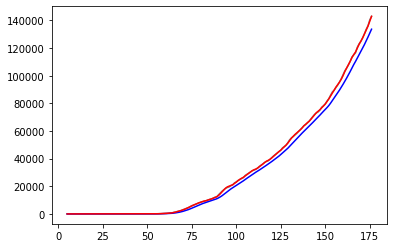

In [199]:
county = 'Los Angeles'
plt.plot('days', 'cases', data=df[df['county'] == county], color='gray')
plt.plot('days', 'cases_7d', data=df[df['county'] == county], color='blue')
plt.plot('days', 'cases_7s', data=df[df['county'] == county], color='red')

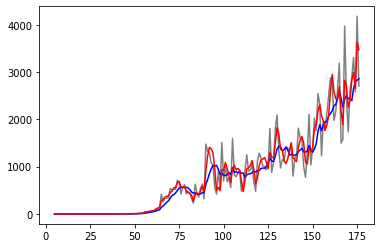

In [200]:
plt.plot('days', 'new_cases', data=df[df['county'] == county], color='gray')
plt.plot('days', 'new_cases_7d', data=df[df['county'] == county], color='blue')
plt.plot('days', 'new_cases_7s', data=df[df['county'] == county], color='red')

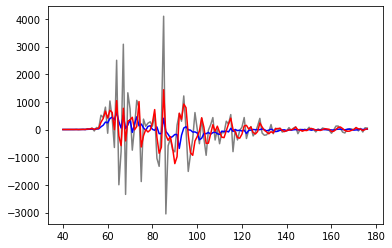

In [197]:
plt.plot('days', 'delta_new_cases', data=df[df['fips'] == 'nyc'], color='gray')
plt.plot('days', 'delta_new_cases_7d', data=df[df['fips'] == 'nyc'], color='blue')
plt.plot('days', 'delta_new_cases_7s', data=df[df['fips'] == 'nyc'], color='red')

In [ ]:
df6.to_csv('data/df-1.csv', index=False)

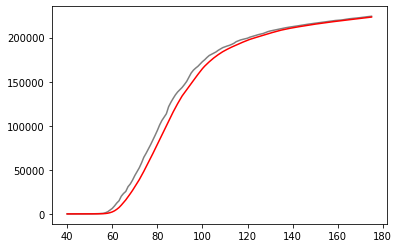

In [ ]:
plt.plot('days', 'cases', data=df[df['county'] == 'New York City'], color='gray')
plt.plot('days', 'cases_7d', data=df[df['county'] == 'New York City'], color='red')

In [202]:
df[df['county'] == 'New York City']['new_cases'].cumsum()

3823         0.0
3824         0.0
3825         1.0
3826         1.0
3827         3.0
          ...   
3955    223381.0
3956    223724.0
3957    223976.0
3958    224292.0
3959    224661.0
Name: new_cases, Length: 137, dtype: float64

In [201]:
df[df['county'] == 'New York City']['new_cases_7s'].cumsum()

3823         0.0000
3824         1.0000
3825         1.8333
3826         2.1000
3827         3.4000
           ...     
3955    223349.6429
3956    223693.0358
3957    223999.7144
3958    224306.9287
3959    224638.7858
Name: new_cases_7s, Length: 137, dtype: float64

In [233]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

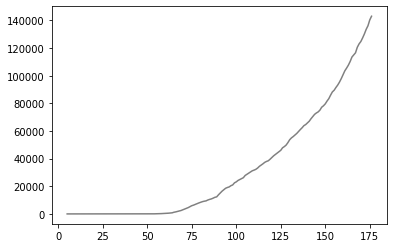

In [237]:
# https://stackoverflow.com/a/42648353



In [216]:
x.max()

176

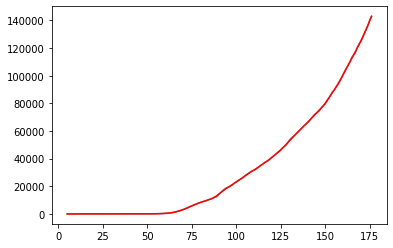

<Figure size 1080x720 with 0 Axes>

In [245]:
x = df[df['county']==county]['days'].values
y = df[df['county']==county]['cases'].values
plt.plot(x, y, color='gray')
plt.plot(x, savgol_filter(y, 7, 1), color='red')
plt.figure(figsize=(15, 10))
plt.show()